In [83]:
# ==== Colab initialization (for personal branch only) ====
# This cell is only for running in Google Colab to load files.
# IMPORTANT: Please remove or comment out before creating a PR to main.
!git clone https://github.com/avril-rdgz/E_EORM_AECTR_GA2.git
%cd E_EORM_AECTR_GA2


Cloning into 'E_EORM_AECTR_GA2'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 63 (delta 22), reused 13 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 1.96 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2


In [84]:
# Put all library imports in this block!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [85]:
# Data prep
data_vintage = pd.read_csv('2025-08-MD.csv')
data_vintage = data_vintage[['sasdate', 'UNRATE', 'INDPRO']]
data_vintage = data_vintage.iloc[1:].copy()

df_log_diff = pd.DataFrame()
df_log_diff['DATE'] = pd.to_datetime(data_vintage['sasdate'])
df_log_diff['UNRATE'] = np.log(data_vintage['UNRATE']).diff()
df_log_diff['INDPRO'] = np.log(data_vintage['INDPRO']).diff()
df_log_diff = df_log_diff.iloc[1:].copy()

display(df_log_diff.head())

,DATE,UNRATE,INDPRO
2,1959-02-01,-0.016807,0.019395
3,1959-03-01,-0.052186,0.014300
4,1959-04-01,-0.074108,0.021080
5,1959-05-01,-0.019418,0.014954
6,1959-06-01,-0.019803,0.001137


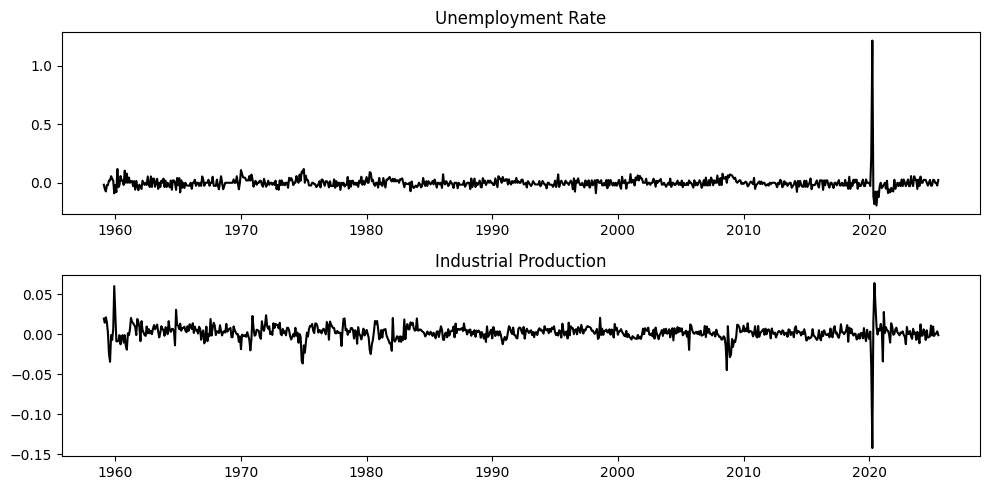

In [86]:
# Plotting log differences
plt.figure(figsize=(10,5))

## Unemployment rate
plt.subplot(2,1,1)
plt.plot(df_log_diff['DATE'], df_log_diff['UNRATE'], color='black')
plt.title('Unemployment Rate')

## Industrial production
plt.subplot(2,1,2)
plt.plot(df_log_diff['DATE'], df_log_diff['INDPRO'], color='black')
plt.title('Industrial Production')

plt.tight_layout()
plt.show()

# Question 2

In [87]:
model_names = ('AR(1)', 'SESTAR', 'STAR')

def get_total_loss(theta, model_name, x, y = None):
  mu, delta, gamma, alpha, beta = theta
  x = np.asarray(x)
  y = np.asarray(y)

  div = 0

  if model_name == 'SESTAR':
    div = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  resid = x[1:] - mu - (delta + div) * x[:-1]

  return np.sum(resid**2)

In [88]:
# Test point for total loss (OK)
theta_star = (0, 0.3, 1, 0, 2)

for model in model_names:
  total_loss = get_total_loss(theta_star, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

Total Loss for AR(1): 2.420311
Total Loss for SESTAR: 2.687785
Total Loss for STAR: 3.652962


In [89]:
# Results for Q2

theta_tilde = (0, 0.1, 2, 0, 3)
results_Q2 = {}

for model in model_names:
  total_loss = get_total_loss(theta_tilde, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

  results_Q2[model] = {
      'total_loss': total_loss
  }

Total Loss for AR(1): 2.329560
Total Loss for SESTAR: 2.847958
Total Loss for STAR: 5.435420


# Question 3

In [90]:
def estimate_model(theta_init, model_name, x, y=None):

  result = minimize(get_total_loss,
                    theta_init,
                    args=(model_name, x, y),
                    method='L-BFGS-B')

  if model_name not in model_names:
    raise ValueError('Invalid model name specified.')

  if not result.success:
    print(f'\nWarning: Optimization failed for {model_name}.')
    print(f'Message: {result.message}\n')
  else:
    print(f'\nOptimization successful for {model_name}. Total Loss: {result.fun:.6f}\n')

  return result.x, result.fun

def fit_values(theta, model_name, x, y=None):
  mu, delta, gamma, alpha, beta = theta
  x = np.asarray(x)
  if y is not None: y = np.asarray(y)

  div = np.zeros_like(x)
  if model_name == 'SESTAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  x_fit = mu + (delta + div) * x

  # Replace 1st observation w/ unconditional mean to remove spike
  if model_name == 'SESTAR':
    x_fit[0] = mu / (1 - delta)

  return x_fit


Initial loss: 2.420311

Optimization successful for AR(1). Total Loss: 2.329415



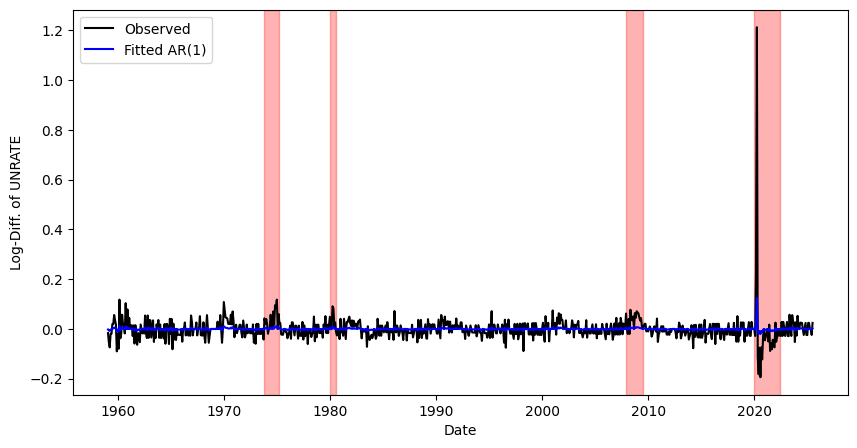

Initial loss: 2.420311

Optimization successful for SESTAR. Total Loss: 2.175516



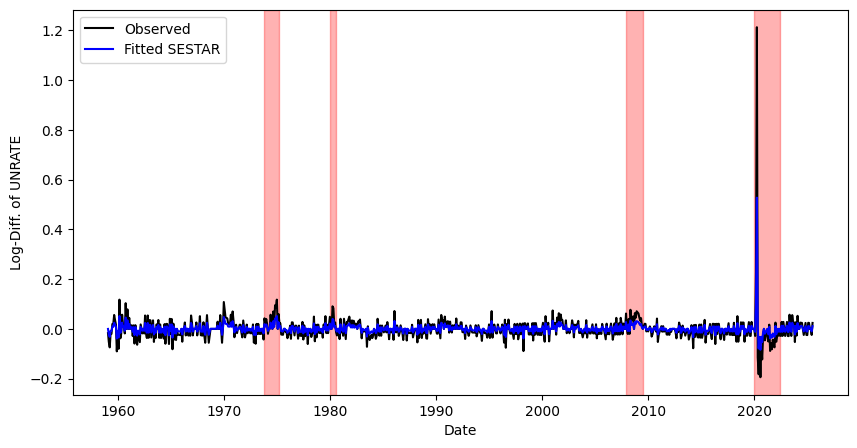

Initial loss: 2.420311

Optimization successful for STAR. Total Loss: 2.175517



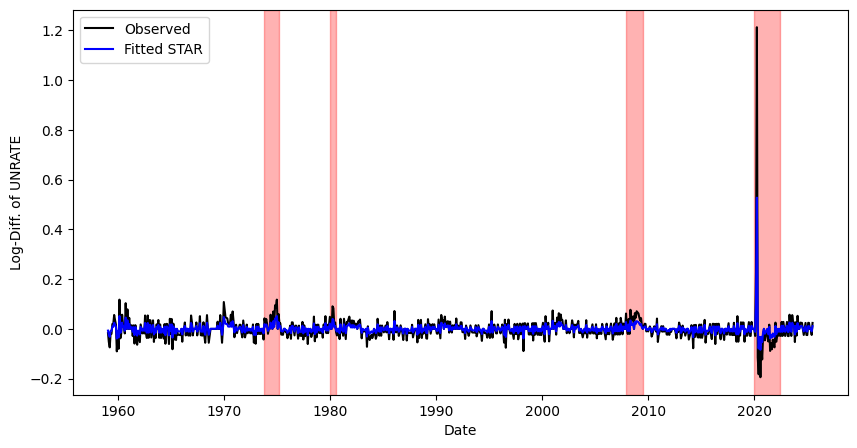

Initial loss: 2.420311

Optimization successful for AR(1). Total Loss: 2.329415



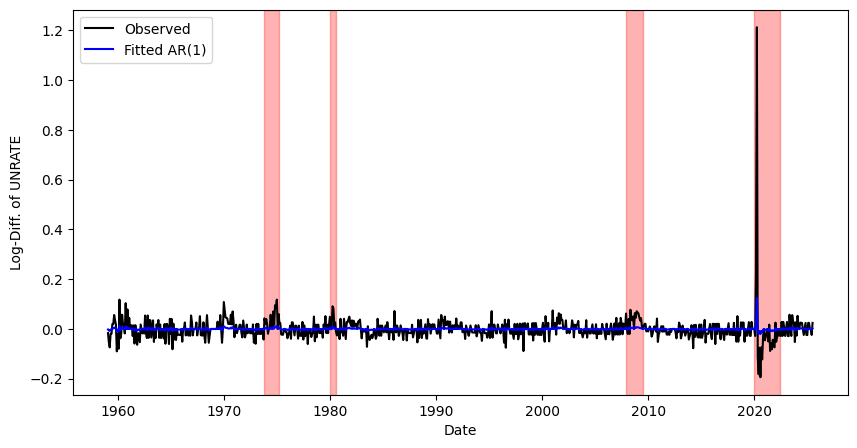

Initial loss: 2.420311

Optimization successful for SESTAR. Total Loss: 2.175516



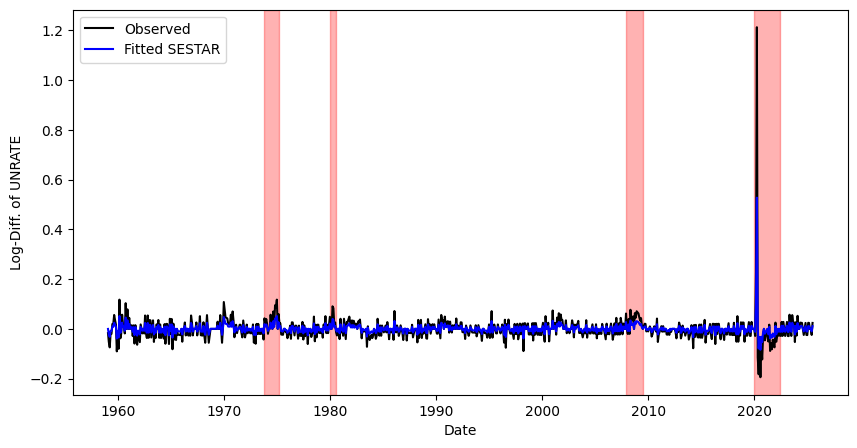

Initial loss: 2.420311

Optimization successful for STAR. Total Loss: 2.175517



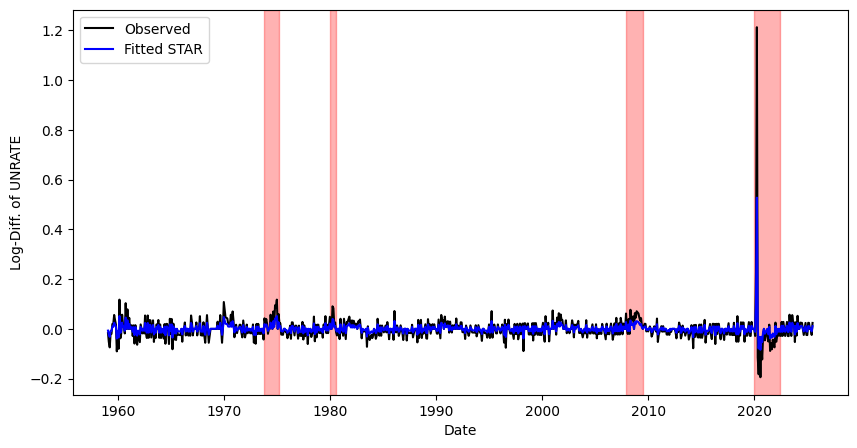

In [91]:
# Results for Q3

theta_init = (0, 0.3, 0, 0, 6)
date = df_log_diff['DATE']
x = df_log_diff['UNRATE']
y = df_log_diff['INDPRO']

recessions_periods = [
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('2007-12-01', '2009-06-30'),
    ('2020-01-01', '2022-05-31')
]

results_Q3 = {}

for model in model_names:

  loss_init = get_total_loss(theta_init, model, x, y)
  print(f'Initial loss: {loss_init:.6f}')

  theta_optim, loss_optim = estimate_model(theta_init, model, x, y)
  results_Q3[model] = {
      'theta': theta_optim,
      'total_loss': loss_optim
  }

  x_fitted = fit_values(theta_optim, model, x, y)

  # Plotting actual vs fitted values
  plt.figure(figsize=(10, 5))
  plt.plot(date, x, label='Observed', color='black')
  plt.plot(date, x_fitted, label=f'Fitted {model}', color='blue')

  for start, end in recessions_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3)

  plt.xlabel('Date')
  plt.ylabel('Log-Diff. of UNRATE')
  plt.legend()

  # Uncomment to store plot
  plt.savefig(f'UNRATE_fitted_{model}.png', bbox_inches='tight', dpi=300)
  plt.show()

  plt.close()

# Results for Q3

theta_init = (0, 0.3, 0, 0, 6)
date = df_log_diff['DATE']
x = df_log_diff['UNRATE']
y = df_log_diff['INDPRO']

recessions_periods = [
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('2007-12-01', '2009-06-30'),
    ('2020-01-01', '2022-05-31')
]

results_Q3 = {}

for model in model_names:

  loss_init = get_total_loss(theta_init, model, x, y)
  print(f'Initial loss: {loss_init:.6f}')

  theta_optim, loss_optim = estimate_model(theta_init, model, x, y)
  results_Q3[model] = {
      'theta': theta_optim,
      'total_loss': loss_optim
  }

  x_fitted = fit_values(theta_optim, model, x, y)

  # Plotting actual vs fitted values
  plt.figure(figsize=(10, 5))
  plt.plot(date, x, label='Observed', color='black')
  plt.plot(date, x_fitted, label=f'Fitted {model}', color='blue')

  for start, end in recessions_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3)

  plt.xlabel('Date')
  plt.ylabel('Log-Diff. of UNRATE')
  plt.legend()

  # Uncomment to store plot
  plt.savefig(f'UNRATE_fitted_{model}.png', bbox_inches='tight', dpi=300)
  plt.show()

  plt.close()

theta_hat_star = np.asarray(results_Q3["STAR"]["theta"])


# Question 4

In [92]:
assert "STAR" in results_Q3
print("θ̂_STAR =", results_Q3["STAR"]["theta"])


θ̂_STAR = [ 5.87615812e-04  4.34545348e-01 -2.43609106e+03  2.61317829e+01
  1.24592045e+02]


In [93]:
assert len(theta_hat_star) == 5

date = pd.to_datetime(df_log_diff["DATE"])


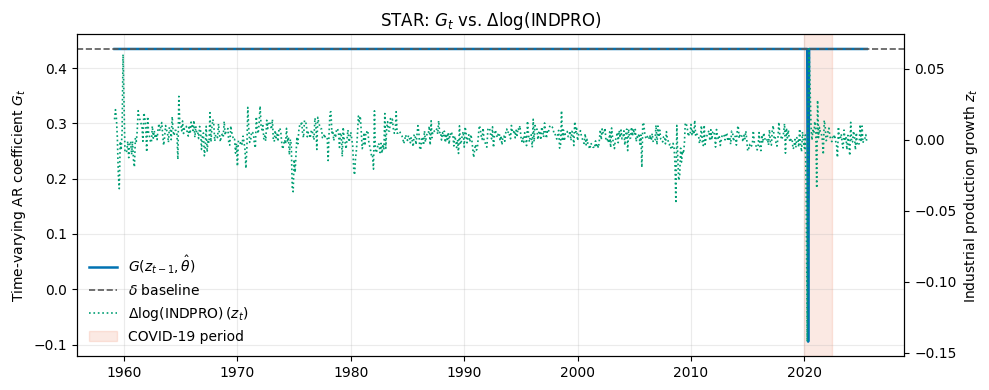

In [94]:
# Results for Q4 (plot G_t and z_t with current θ̂_STAR)

# 1) Parameters and series
mu, delta, gamma, alpha, beta = np.asarray(results_Q3["STAR"]["theta"])
date = pd.to_datetime(df_log_diff["DATE"])
z = df_log_diff["INDPRO"].to_numpy()

# 2) Logistic and alignment
def logistic(u):
    """1/(1+exp(u)) with clipping for numerical stability."""
    u = np.clip(u, -30, 30)
    return 1.0 / (1.0 + np.exp(u))

G          = delta + gamma * logistic(alpha + beta * z[:-1])  # length T-1 uses z_{t-1}
z_align    = z[1:]                                            # aligned with G_t
date_align = date[1:]

# 3) Colors (colorblind-safe + warmer orange-red for COVID)
COL_G      = "#0072B2"  # G_t
COL_DELTA  = "#595959"  # δ baseline
COL_Z      = "#009E73"  # z_t
COL_COVID  = "#E64A19"  # COVID period (orange-red)

# 4) Plot
fig, ax1 = plt.subplots(figsize=(10, 4))

(ln1,) = ax1.plot(date_align, G, color=COL_G, lw=1.8,
                  label=r"$G(z_{t-1}, \hat{\theta})$")
ln2 = ax1.axhline(delta, color=COL_DELTA, lw=1.2, ls="--",
                  label=r"$\delta$ baseline")
ax1.set_ylabel(r"Time-varying AR coefficient $G_t$")
ax1.grid(alpha=0.25)

ax2 = ax1.twinx()
(ln3,) = ax2.plot(date_align, z_align, color=COL_Z, lw=1.2, ls=":",
                  label=r"$\Delta\log(\mathrm{INDPRO})\,(z_t)$")
ax2.set_ylabel(r"Industrial production growth $z_t$")

# COVID shading + legend handle
cov_patch = mpatches.Patch(color=COL_COVID, alpha=0.12, label="COVID-19 period")
ax1.axvspan(pd.Timestamp("2020-01-01"), pd.Timestamp("2022-05-31"),
            color=COL_COVID, alpha=0.12, zorder=0)

# Title & legend (bottom-left)
ax1.set_title(r"STAR: $G_t$ vs. $\Delta\log(\mathrm{INDPRO})$")
handles = [ln1, ln2, ln3, cov_patch]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="lower left", frameon=False)

plt.tight_layout()
plt.show()

In [95]:
print("θ̂_STAR =", results_Q3["STAR"]["theta"])
print("Lengths -> G:", len(G), " z_align:", len(z_align), " date_align:", len(date_align))
print("G_t stats -> min:", np.nanmin(G), " max:", np.nanmax(G), " mean:", np.nanmean(G))

# logistic∈(0,1)
lo, hi = (delta + min(0, gamma), delta + max(0, gamma))
print("Theoretical range approx:", (lo, hi))

# sign(dG/dz) = sign(-γβ)
print("sign(dG/dz) =", np.sign(-gamma * beta))


θ̂_STAR = [ 5.87615812e-04  4.34545348e-01 -2.43609106e+03  2.61317829e+01
  1.24592045e+02]
Lengths -> G: 797  z_align: 797  date_align: 797
G_t stats -> min: -0.09479190186739367  max: 0.4345453480177361  mean: 0.4338811629102178
Theoretical range approx: (np.float64(-2435.6565188247782), np.float64(0.4345453482456963))
sign(dG/dz) = 1.0


# Question 5

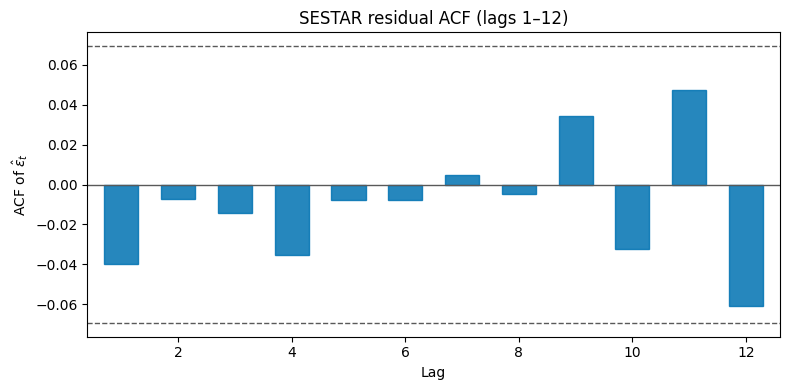

     lb_stat  lb_pvalue
12  9.255384   0.680976

Residual ACF (lags 1..12):
lag  1: -0.040
lag  2: -0.007
lag  3: -0.014
lag  4: -0.036
lag  5: -0.008
lag  6: -0.008
lag  7: +0.005
lag  8: -0.005
lag  9: +0.035
lag 10: -0.032
lag 11: +0.047
lag 12: -0.061

Approx. 95% reference band: ±0.069  (T=797)


In [96]:
# Results for Q5 (SESTAR residuals, ACF (lags 1–12), and Ljung–Box test)

# Ljung–Box - if unavailable = skip
try:
    from statsmodels.stats.diagnostic import acorr_ljungbox
except Exception:
    acorr_ljungbox = None

# 1) Read parameters and series
theta_sestar = np.asarray(results_Q3["SESTAR"]["theta"])
mu, delta, gamma, alpha, beta = theta_sestar
date = pd.to_datetime(df_log_diff["DATE"])
x = df_log_diff["UNRATE"].to_numpy()

# 2) Fitted values and residuals for SESTAR
def logistic(u):
    u = np.clip(u, -30, 30)
    return 1.0 / (1.0 + np.exp(u))

g = gamma * logistic(alpha + beta * x[:-1])
x_hat = mu + (delta + g) * x[:-1]

eps = np.empty_like(x, dtype=float)
eps[:] = np.nan
eps[1:] = x[1:] - x_hat                       # residuals aligned to t>=2

# 3) Sample ACF up to lag 12
eps_valid = eps[1:] - np.nanmean(eps[1:])     # demean, drop first NaN
T = len(eps_valid)

def sample_acf(series, max_lag):
    denom = np.sum(series**2)
    acfs = []
    for h in range(1, max_lag+1):
        num = np.sum(series[h:] * series[:-h])
        acfs.append(num / denom)
    return np.array(acfs)

max_lag = 12
rho = sample_acf(eps_valid, max_lag=max_lag)
ci = 1.96 / np.sqrt(T)  # ~95% reference band for white noise

# 4) Plot ACF bars (single, main figure)
lags = np.arange(1, max_lag+1)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(lags, rho, width=0.6, color="#0072B2", edgecolor="#0072B2", alpha=0.85)
ax.axhline(0, color="#595959", lw=1)
ax.axhline(+ci, color="#595959", lw=1, ls="--")
ax.axhline(-ci, color="#595959", lw=1, ls="--")
ax.set_xlim(0.4, max_lag + 0.6)
ax.set_xlabel("Lag")
ax.set_ylabel(r"ACF of $\hat{\varepsilon}_t$")
ax.set_title("SESTAR residual ACF (lags 1–12)")
plt.tight_layout()
plt.show()

# 5) Ljung–Box test up to lag 12
if acorr_ljungbox is not None:
    lb = acorr_ljungbox(eps_valid, lags=[12], return_df=True)  # columns: lb_stat, lb_pvalue
    print(lb)
else:
    print("statsmodels not available -> skipped Ljung–Box test.")

# 6) Print ACF values and CI
print("\nResidual ACF (lags 1..12):")
for h, r in zip(lags, rho):
    print(f"lag {h:2d}: {r:+.3f}")
print(f"\nApprox. 95% reference band: ±{ci:.3f}  (T={T})")